<a href="https://colab.research.google.com/github/seopp/Tobigs19/blob/main/Week2_optimization_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tobig's 19기 2주차 Optimization 과제

# Gradient Descent 구현하기

### 1)"..."표시되어 있는 빈 칸을 채워주세요
### 2)강의내용과 코드에 대해 공부한 내용을 마크마운 또는 주석으로 설명해주세요

## 데이터

In [90]:
import pandas as pd
import numpy as np
import random

In [91]:
# 데이터를 불러옵니다.
data = pd.read_csv('assignment_2.csv')
data.head()

,Label,bias,experience,salary
0,1,1,0.7,48000
1,0,1,1.9,48000
2,1,1,2.5,60000
3,0,1,4.2,63000
4,0,1,6.0,76000


## Train Test 데이터 나누기

In [92]:
from sklearn.model_selection import train_test_split

In [93]:
# data를 1~3열인 x와 0열인 y로 분리후 train과 test를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size = 0.25, random_state = 0)

In [94]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150, 3), (50, 3), (150,), (50,))

## Scaling

experience와 salary의 단위, 평균, 분산이 크게 차이나므로 scaler를 사용해 단위를 맞춰줍니다. 

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
bias_train = X_train["bias"]
bias_train = bias_train.reset_index()["bias"]
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train["bias"] = bias_train
X_train.head()

,bias,experience,salary
0,1,0.187893,-1.143335
1,1,1.185555,0.043974
2,1,-0.310938,-0.351795
3,1,-1.629277,-1.341220
4,1,-1.308600,0.043974


이때 scaler는 X_train에 fit 해주시고, fit한 scaler를 X_test에 적용시켜줍니다.  
똑같이 X_test에다 fit하면 안돼요!

In [96]:
bias_test = X_test["bias"]
bias_test = bias_test.reset_index()["bias"]
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_test["bias"] = bias_test
X_test.head()

,bias,experience,salary
0,1,-1.344231,-0.615642
1,1,0.508570,0.307821
2,1,-0.310938,0.571667
3,1,1.363709,1.956862
4,1,-0.987923,-0.747565


In [97]:
# parameter 개수
N = len(X_train.loc[0])

In [98]:
# 초기 parameter들을 임의로 설정해줍니다.
parameters = np.array([random.random() for i in range(N)])
random_parameters = parameters.copy()
parameters

array([0.85594404, 0.88197975, 0.12163717])

### * LaTeX   

Jupyter Notebook은 LaTeX 문법으로 수식 입력을 지원하고 있습니다.  
LaTeX문법으로 아래의 수식을 완성해주세요  
http://triki.net/apps/3466  
https://jjycjnmath.tistory.com/117

## Dot product
## $z = X_i \theta$

In [99]:
def dot_product(X, parameters):
    z = 0
    for i in range(len(parameters)):
        z += X[i]*parameters[i]
    return z

## Logistic Function

## $ p = \cfrac{1}{1+e^{-X_i\theta}} $

In [100]:
def logistic(X, parameters):
    z = dot_product(X, parameters)
    p = 1/(1+np.e**z)
    return p

In [101]:
logistic(X_train.iloc[1], parameters)

0.12932629559267728

## Object function

Object Function : 목적함수는 Gradient Descent를 통해 최적화 하고자 하는 함수입니다.  
<br>
선형 회귀의 목적함수
## $l(\theta) = \frac{1}{2}\Sigma(y_i - \theta^{T}X_i)^2$  
참고) $\hat{y_i} = \theta^{T}X_i$
  
로지스틱 회귀의 목적함수를 작성해주세요  
(선형 회귀의 목적함수처럼 강의에 나온대로 작성해주세요. 평균을 고려하는 것은 뒤에 코드에서 수행합니다)
## $l(p) = -\Sigma\{y_i\log p (X_i) + (1-y_i)\log(1-p(X_i))\}$

In [102]:
def minus_log_cross_entropy_i(X, y, parameters):
    p = logistic(X, parameters)
    loss = -(y*np.log1p(p) + (1-y)*np.log1p(1-p))
    return loss

In [103]:
def mse_i(X, y, parameters):
    y_hat = dot_product(X, parameters)
    loss = np.sum(y-y_hat)**2 / 2
    return loss

In [104]:
def batch_loss(X_set, y_set, parameters, loss_function, n): 
    loss = 0
    for i in range(X_set.shape[0]):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        loss += loss_function(X,y, parameters)
    loss = loss/X_set.shape[0]
    return loss

In [105]:
batch_loss(X_test, y_test, parameters, minus_log_cross_entropy_i, len(X_test))

-0.4619682542552468

## Gradient
위의 선형회귀의 목적함수 $l(\theta)$와 로지스틱회귀의 목적함수 $l(p)$의 gradient를 작성해주세요  
(위의 목적함수를 참고해서 작성해주세요 = 평균을 고려하는 것은 뒤에 코드에서 수행합니다)

## ${\partial\over{\partial \theta_j}}l(\theta)= -\Sigma(y_i - \theta^TX_i)X_{ij}$
## ${\partial\over{\partial \theta_j}}l(p)=-\Sigma(y_i-p_i)X_{ij}$

In [106]:
def get_gradient_ij(X, y, parameters, j, model):
    if model == 'linear':
        y_hat = dot_product(X, parameters)
        gradient = -(y-y_hat)*X[j]
    else:
        p = logistic(X, parameters)
        gradient = -(y-p)*X[j]
    return gradient

In [107]:
get_gradient_ij(X_train.iloc[0,:], y_train.iloc[0], parameters, 1, 'logistic')

-0.13290776176537716

## Batch Gradient
하나의 배치 (X_set, y_set)에 대해 기울기를 구하는 코드를 작성해주세요

In [108]:
def batch_gradient(X_set, y_set, parameters, model):
    gradients = [0 for _ in range(len(parameters))]
    
    for i in range(X_set.shape[0]):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        for j in range(len(parameters)):
            gradients[j] += get_gradient_ij(X, y, parameters, j, model)
    
    return gradients

In [109]:
gradients1 = batch_gradient(X_train, y_train, parameters, 'logistic')
gradients1

[7.819298541262986, -45.74994104646562, -7.790039988664559]

## mini-batch
인덱스로 미니 배치 나누기

In [110]:
def batch_idx(X_train, batch_size):
    N = len(X_train)
    nb = (N // batch_size)+1 #number of batch
    idx = np.array([i for i in range(N)])
    idx_list = [idx[i*batch_size:(i+1)*batch_size] for i in range(nb) if len(idx[i*batch_size:(i+1)*batch_size]) != 0]
    return idx_list

batch_idx 함수에 대한 설명을 batch_size와 함께 간략하게 작성해주세요  
### 설명: batch_idx 함수는 데이터를 batch_size만큼 나누어 각 mini-batch에 해당하는 인덱스 리스트를 return하는 함수이다.

## Update Parameters
기울기를 갱신하는 코드를 작성해주세요  
(loss와 마찬가지로 기울기를 갱신할 때 배치 사이즈를 고려해 평균으로 갱신해주세요)

In [111]:
def step(parameters, gradients, learning_rate, n): # n : 데이터 수
    for i in range(len(parameters)):
        gradients[i] *= learning_rate/n # 기울기 갱신
    
    parameters -= gradients
    return parameters

In [112]:
step(parameters, gradients1, 0.01, len(X_train))

array([0.85542275, 0.88502975, 0.1221565 ])

## Gradient Descent
위에서 작성한 함수들을 조합해서 경사하강법 함수를 완성해주세요

- learning_rate: 학습률  
- tolerance: Step이 너무 작아서 더 이상의 학습이 무의미할 때 학습을 멈추는 조건  
- batch: 기울기를 1번 갱신할 때 사용하는 데이터셋  
- epoch:  한 번의 epoch는 전체 데이터 셋에 대해 한 번 학습을 완료한 상태
- num_epoch: 경사하강법 반복 횟수
<br>

BGD: (=Batch gradient descent) 전체 데이터 셋에 대한 에러를 구한 뒤 기울기를 한번만 계산하여 모델의 parameter 를 업데이트 하는 방법

SGD: (=Stochastic gradient descent) 추출된 데이터 한 개에 대해서 error gradient 를 계산하고, Gradient descent 알고리즘을 적용하는 방법

MGD: (=Minibatch Gradient Descent) SGD와 BGD의 절충안으로 전체 데이터를 batch_size개씩 나눠 배치로 학습시키는 방법

<br>
batch_size에 따른 경사하강법의 종류를 적어주세요  

batch_size=1 -> SGD

batch_size=k -> MGD  

batch_size=whole -> BGD

In [113]:
def gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 16):
    stopper = False
    
    N = len(X_train.iloc[0])
    parameters = np.random.rand(N)
    loss_function = minus_log_cross_entropy_i if model == 'logistic' else mse_i
    loss = 999
    batch_idx_list = batch_idx(X_train, batch_size)
    
    for epoch in range(num_epoch):
        if stopper:
            break
        for idx in batch_idx_list:
            X_batch = X_train.iloc[idx,]
            y_batch = y_train.iloc[idx]
            gradients = batch_gradient(X_batch, y_batch, parameters, model)
            parameters = step(parameters, gradients, learning_rate, batch_size)
            new_loss = batch_loss(X_batch, y_batch, parameters, loss_function, batch_size)
            
            #중단 조건
            if abs(new_loss - loss) < tolerance:
                stopper = True
                break
            loss = new_loss
        
        #100epoch마다 학습 상태 출력
        if epoch%100 == 0: #출력이 길게 나오면 check point를 수정해도 됩니다.
            print(f"epoch: {epoch}  loss: {new_loss}  params: {parameters}  gradients: {gradients}")
    
    return parameters

## Implement
경사하강법 함수를 이용해 최적의 모수 찾아보세요. 학습을 진행할 때, Hyper Parameter를 바꿔가면서 학습시켜보세요.

## Logistic Regression

In [120]:
new_param_bgd = gradient_descent(X_train, y_train, batch_size = X_train.shape[0]) # bgd 이므로 batch_size는 전체
new_param_bgd

epoch: 0  loss: -0.38130807786924664  params: [0.03443549 0.70061428 0.76887663]  gradients: [0.021503780629679482, -0.03626025636477637, -0.01457797462078136]
epoch: 100  loss: -0.27485356484384366  params: [-3.08352369  5.52130489  3.0596671 ]  gradients: [0.034651934607750595, -0.05086922813626237, -0.024484566751036725]
epoch: 200  loss: -0.2616834038821365  params: [-6.67078329 10.6027805   5.48831799]  gradients: [0.03677177478731987, -0.050670342803197786, -0.024102647149530393]
epoch: 300  loss: -0.2573254134839019  params: [-10.4010347   15.65398966   7.88653259]  gradients: [0.037706324754484453, -0.0503770110258741, -0.02388514062628805]
epoch: 400  loss: -0.2552808405926788  params: [-14.19789845  20.68179508  10.26737716]  gradients: [0.03818138789670495, -0.050195598181025945, -0.02373898220478745]
epoch: 500  loss: -0.2539935558706795  params: [-18.0318916   25.69502888  12.63499131]  gradients: [0.03847686131212502, -0.050077366581463154, -0.02361741923483553]


array([-19.53433741,  27.6473016 ,  13.55519639])

In [121]:
new_param_sgd = gradient_descent(X_train, y_train, batch_size = 1) # sgd이므로 batch_size는 1
new_param_sgd

epoch: 0  loss: -0.6868367057263729  params: [-2.67444322  7.67641342  4.06460922]  gradients: [0.0012553308335792965, 0.0006831522403177352, 0.000883239152389387]


array([-2.77413811,  8.08859849,  4.19834974])

In [122]:
new_param_mgd = gradient_descent(X_train, y_train, batch_size = 16) # mgd이므로 batch_size는 16
new_param_mgd

epoch: 0  loss: -0.5174273571688338  params: [0.26208189 1.2822018  0.13759154]  gradients: [0.0019522095409459416, 0.00019177696101048067, 0.005837500710840518]
epoch: 100  loss: -0.5655173149536074  params: [-33.42544191  48.88363985  22.2808929 ]  gradients: [0.00537244948542377, -0.000541892133135791, 0.0032385425062845595]
epoch: 200  loss: -0.577592969461521  params: [-69.85856152  95.79817669  44.03804405]  gradients: [0.006247782472843295, 5.9344899689788435e-05, 0.00316086511622527]
epoch: 300  loss: -0.5776226097602043  params: [-106.74173134  142.5245584    65.51519843]  gradients: [0.006249997490668664, 6.086750593845893e-05, 0.0031606619769089777]
epoch: 400  loss: -0.5776226503159858  params: [-143.70617922  189.19818281   86.97498078]  gradients: [0.006250000005035009, 6.086927121706179e-05, 0.0031606615413838635]
epoch: 500  loss: -0.5776226504627221  params: [-180.80423173  235.76887191  108.43463232]  gradients: [0.006250000000284352, 6.086926907400435e-05, 0.00316066

<ipython-input-100-9b11047acc53>:3: RuntimeWarning: overflow encountered in double_scalars
  p = 1/(1+np.e**z)


epoch: 700  loss: -0.5776226504665846  params: [-256.35479901  327.96759038  151.12690774]  gradients: [0.0062500000000027135, 6.086926892113859e-05, 0.00316066153538478]
epoch: 800  loss: -0.5776226504666063  params: [-295.03189593  373.511517    172.15951085]  gradients: [0.006250000000001097, 6.086926892025861e-05, 0.0031606615353836423]
epoch: 900  loss: -0.5776226504666128  params: [-333.91071509  418.94836452  193.07913298]  gradients: [0.006250000000000622, 6.08692689200005e-05, 0.003160661535383309]


array([-372.75312671,  463.76369153,  213.54285039])

### Predict Label

In [142]:
y_predict = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_sgd) # sgd의 parameter 사용
    if p> 0.5 :
        y_predict.append(1)
    else :
        y_predict.append(0)
y_predict_random = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], random_parameters)
    if p> 0.5 :
        y_predict_random.append(1)
    else :
        y_predict_random.append(0)

### Confusion Matrix

In [143]:
from sklearn.metrics import *

In [144]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
confusion_matrix(y_test, y_predict)

array([[22, 18],
       [ 6,  4]])

In [145]:
accuracy = (tp+tn) / (tp+fn+fp+tn)
print("accuracy:",accuracy) # sgd의 accuracy가 가장 좋게 나와 사용

accuracy: 0.52


## Linear regression
### $y = 0.5 + 2.7x$

### Data

In [127]:
raw_X = np.random.rand(150)
y = 2.7*raw_X + 0.5 + np.random.randn(150)

In [128]:
tmp = np.array([1 for _ in range(150)])
X = np.vstack((tmp, raw_X)).T
X = pd.DataFrame(X)
y = pd.Series(y)

### Estimation

In [129]:
#정규방정식
theta = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)
theta

array([0.71816459, 2.37071359])

In [135]:
#경사하강법
new_param = gradient_descent(X, y, learning_rate = 0.01, num_epoch = 1000, model='linear', batch_size = 32) # batch_size를 32로 변경, linear 모델 사용, 학습률 0.01
new_param

epoch: 0  loss: 1.4327784051977515  params: [0.19834214 0.91605738]  gradients: [-0.010969095946621956, -0.006221345212403494]
epoch: 100  loss: 0.2133606841793055  params: [1.08677999 1.6823172 ]  gradients: [-0.0019069161361609755, -0.0009310398724420143]
epoch: 200  loss: 0.2157602879958093  params: [0.99862102 1.85244466]  gradients: [-0.0018747740020205411, -0.0008363494280002331]
epoch: 300  loss: 0.2194654342704194  params: [0.93022441 1.9797826 ]  gradients: [-0.0018674401578570854, -0.0007745968002000565]
epoch: 400  loss: 0.22297060524917967  params: [0.87861813 2.07584978]  gradients: [-0.0018619492128202273, -0.0007280318095455603]
epoch: 500  loss: 0.22601821111178824  params: [0.83968392 2.14832734]  gradients: [-0.00185780669171968, -0.0006929010636005197]
epoch: 600  loss: 0.2285469290641022  params: [0.81031013 2.2030078 ]  gradients: [-0.0018546813804039355, -0.0006663967866929335]
epoch: 700  loss: 0.2305853193308317  params: [0.78814917 2.2442613 ]  gradients: [-0.0

array([0.74938219, 2.31642758])

In [136]:
y_hat_NE = theta.dot(X.T)
y_hat_GD = new_param.dot(X.T)

### Visualization
시각화를 통해 정규방정식과 경사하강법을 통한 선형회귀를 비교해보세요  
(밑의 코드를 실행만 시키면 됩니다. 추가 코드 x)

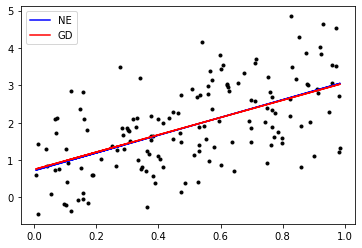

In [137]:
import matplotlib.pyplot as plt
plt.plot(X.iloc[:,1], y, '.k') #산점도
plt.plot(X.iloc[:,1], y_hat_NE, '-b', label = 'NE') #정규방정식
plt.plot(X.iloc[:,1], y_hat_GD, '-r', label = 'GD') #경사하강법
plt.legend()
plt.show()